In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

In [4]:
# To ensure reproducibility and consistent results across runs
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
# Keep original 28x28 images
transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

100.0%
100.0%
100.0%
100.0%


In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Training set: {len(train_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Training set: 60000 images
Test set: 10000 images


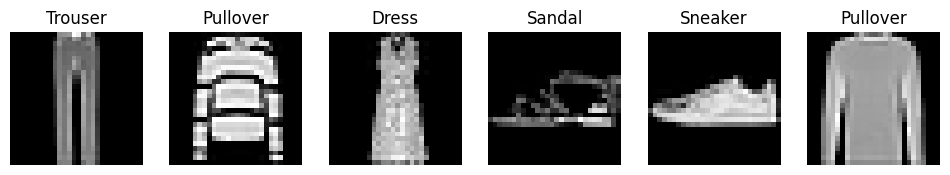

In [25]:
classes = train_dataset.classes

def show_samples():
    images, labels = next(iter(train_loader))
    fig, axes = plt.subplots(1, 6, figsize=(12, 3))
    for i in range(6):
        axes[i].imshow(images[i].squeeze(), cmap='gray')
        axes[i].set_title(classes[labels[i]])
        axes[i].axis('off')
    plt.show()

show_samples()

In [9]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.flatten(x)  # Flatten 28x28 → 784
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = MLP().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



Using device: cpu


In [12]:
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {total_loss/len(train_loader):.4f}")

Epoch [1/5] - Loss: 0.5305
Epoch [2/5] - Loss: 0.3700
Epoch [3/5] - Loss: 0.3309
Epoch [4/5] - Loss: 0.3038
Epoch [5/5] - Loss: 0.2902


In [13]:
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 87.34%
